In [1]:
import pandas as pd
pd.set_option('max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from utils import *
%matplotlib notebook

%load_ext autoreload
%autoreload 2
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

# 0 - Problem Statement
The goal of this notebook is to show possible usage of Random Forest regressor for timeseries forecasting; in the notebook multiple example are given with the usage of a general purpose library.<br>
The notebook contains the following sections:

1. Introduction to univariate & multivariate timeseries datasets
2. Cross validation: two different techniques
3. CART regressor on univariate timeseries
4. CART on multivariate timeseries
5. OPTIONAL LSTM

# 1 - Introduction to univariate & multivariate timeseries datasets
A timeseries without covariates is an "univariate" timeseries.<br>
Here below an example of female births dataset, that is the monthly births across three years. <br>
Credits: <br>
https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv <br>
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

<IPython.core.display.Javascript object>


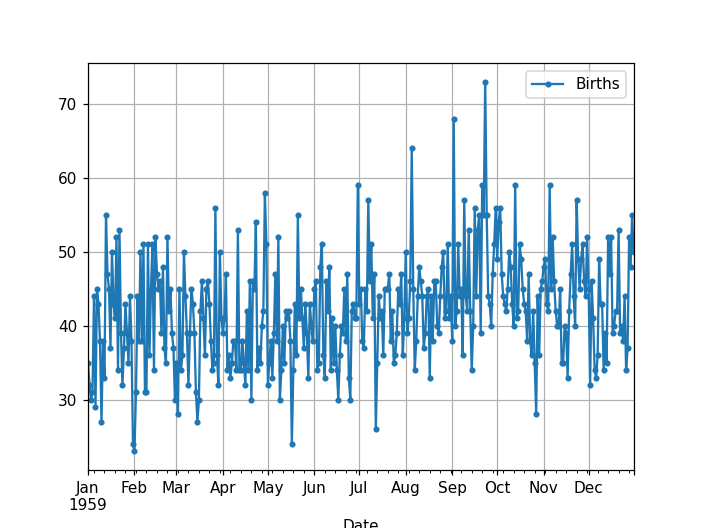

In [2]:
filename = 'daily-total-female-births.csv'
# load the dataset
series = pd.read_csv(filename, header=0, index_col=0, parse_dates=True)
values = series.values

# plot dataset
ax = series.plot(style='.-')
ax.grid()
plt.show(block=False)

A timeseries with covariates is a multivaraite timeseries.<br>
This dataset contains 19 different features such as air temperature, atmospheric pressure, and humidity collected from 2009 to 2016 with 1 records every hour.<br>
Credits: <br>https://www.bgc-jena.mpg.de/wetter/ <br>https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip <br>
https://www.tensorflow.org/tutorials/structured_data/time_series

<IPython.core.display.Javascript object>


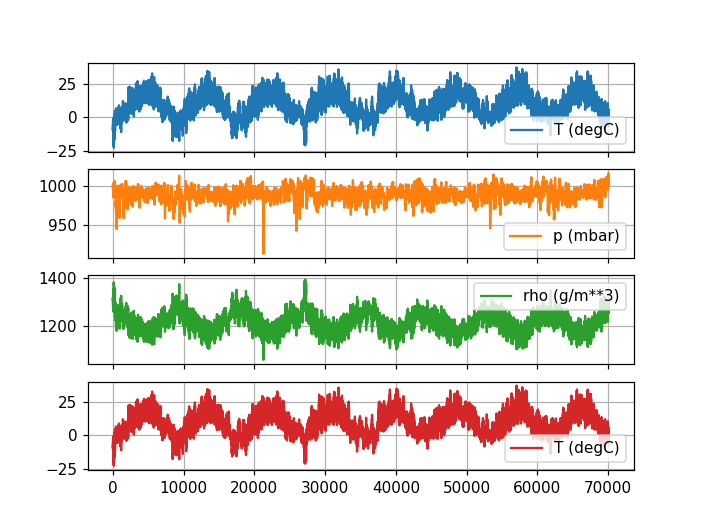

In [3]:
filename = 'weather_dataset.csv'
# load the dataset
data = pd.read_csv(filename, header=0, index_col=0, parse_dates=True)

# plot some features
feat = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'T (degC)']
data.plot(y=feat,style='-',grid=True,subplots=True)
plt.show(block=False)

The models in this notebook will make a set of predictions on both datasets based on a window of consecutive samples. <br>

The main features of the input windows are:

- The width (number of time steps) of the input and label windows. (parameter "n_in")
- The time offset between them. (parameter "n_ahead")
- Single-time-step and multi-time-step predictions. (parameter "single_output")
- Single-output or multi-output predictions. (for multivariate only)

This notebook will use the function "series_to_supervised" to do the data windowing.<br>


<img src="figures/TS_exaplained_pw.png">

Here below an example of the usage of the "series_to_supervised" function.<br>
Timestamps till <b>t-1</b> are the training samples.

In [4]:
############## Params START ##############
n_in = 6 # Number of "previous data" to use as input
n_ahead = 4 # Number of step ahead to predict
single_output = False # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
n_out = 1 if single_output else n_ahead # Number of outputs of the model
filename = 'daily-total-female-births.csv'
############## Params End ##############

# load the dataset
series = pd.read_csv(filename, header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=n_in, n_out=n_ahead, single_output=single_output)
data.head()

,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3)
6,35.0,32.0,30.0,31.0,44.0,29.0,45,43.0,38.0,27.0
7,32.0,30.0,31.0,44.0,29.0,45.0,43,38.0,27.0,38.0
8,30.0,31.0,44.0,29.0,45.0,43.0,38,27.0,38.0,33.0
9,31.0,44.0,29.0,45.0,43.0,38.0,27,38.0,33.0,55.0
10,44.0,29.0,45.0,43.0,38.0,27.0,38,33.0,55.0,47.0


In [5]:
############## Params START ##############
n_in = 2 # Number of "previous data" to use as input
n_ahead = 2 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
n_out = 1 if single_output else n_ahead # Number of outputs of the model
filename = 'weather_dataset.csv'
############## Params End ##############

# load the dataset
df = pd.read_csv(filename, header=0, index_col=0)
df = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'T (degC)']]

# transform the time series data into supervised learning
data = series_to_supervised(df.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
data.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t+1),var2(t+1),var3(t+1),var4(t+1)
2,-8.05,996.50,1307.86,-8.05,-8.88,996.62,1312.25,-8.88,-9.05,996.99,1313.61,-9.05
3,-8.88,996.62,1312.25,-8.88,-8.81,996.84,1312.18,-8.81,-9.63,997.46,1317.19,-9.63
4,-8.81,996.84,1312.18,-8.81,-9.05,996.99,1313.61,-9.05,-9.67,997.71,1317.71,-9.67
5,-9.05,996.99,1313.61,-9.05,-9.63,997.46,1317.19,-9.63,-9.17,998.33,1315.98,-9.17
6,-9.63,997.46,1317.19,-9.63,-9.67,997.71,1317.71,-9.67,-8.10,999.17,1311.65,-8.10


# 2 - Cross validation: two different techniques
The classical k-fold cross validation cannot be used for timeseries problems because the "shuffling" of the records can causa data leakage: information from the future will "leak" into the current prediction.<br>
For this reason, two different cross-validation techniques are applied:

- Sliding vs Expanding windows
- Walk forward cross validation

## 2.1 Sliding vs Examping window
The difference between sliding and expanding windows it is in the train dataset dimension: in the sliding window it is fixed, in the expanding window increases with the training. For both techniques the number of splits are specified by the user. <br>
Figures credits: https://www.analyticsvidhya.com/blog/2021/06/random-forest-for-time-series-forecasting/

<img src="figures/SlidingExpanding.png">

In this notebook only expanding window will be used since it uses most of the data for the training. <br>
Here below an example of the expanding window approach: <br>
Dataset credits: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

<IPython.core.display.Javascript object>


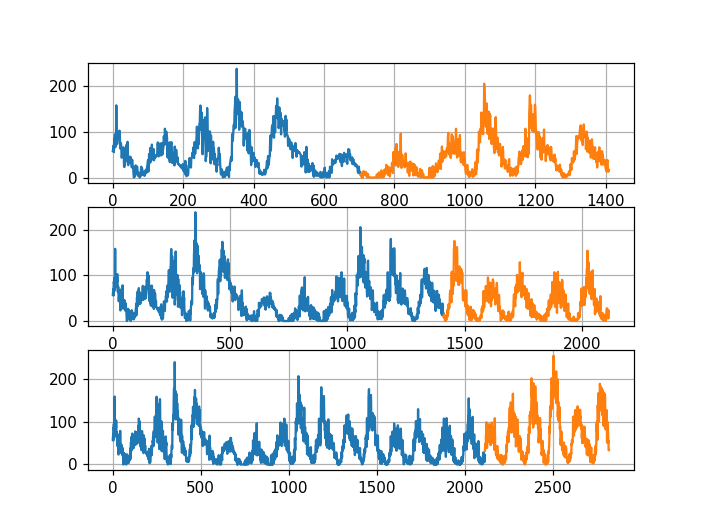

Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


In [6]:
series = pd.read_csv('sunspots.csv', header=0, index_col=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure()
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index][:,0]
    test = X[test_index][:,0]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(3,1,0 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    plt.grid()
    index += 1
plt.show()

## 2.2 Walk forawd cross validation
Walk forward cross validation is a particular case of expanding window where the dimension of the test set is of one record only, so the number of splits will be equal to the number of test sample used for cross validation (parameter "n_test" for function "walk_forward_validation").

<img src="figures/splits.png">

# 3 - CART regressor on univariate timeseries
The main goal of this notebook is to use CART (Classification And Regression Tree) methods for timeseries forecasting. <br>
In this section multiple example of usage are presented and, each time a new CART methodology is used, the main parameter are described.<br>

<b>NOTE:</b> Two naive models are used for performance comparison:
- The persistence model which simply predicts based on last seen record.
- The mean model which simply predicts the average of the training samples.

<b>NOTE:</b> the metric used to compare the model is the Mean Absolute Error (MAE); other metrics can be used but they are out of scope with respect to this notebook.

## 3.1 Univariate Analysis
In this section three differnt CART techniques will be described and applied to the univariate case. This case is trivial but it will be used as a reference case for each technique.

In [7]:
output_metrics = pd.DataFrame(data={'Persistence':[float('nan'),float('nan')],
                                    'Mean':[float('nan'),float('nan')],
                                    'DecisionTree':[float('nan'),float('nan')],
                                    'RandomForest':[float('nan'),float('nan')],
                                    'GradientBoosting':[float('nan'),float('nan')],
                                    'SuperLearner':[float('nan'),float('nan')]},index=['MAE','RMSE'])

### 3.1.1 - Decision Tree Regressor
The Decision Tree Regressor is the first CART used in this notebook. The main parameters of this CART are the following:
- "criterion": the greedy algorithm based on the CART training process, need a function to decide the best split. The criterion specifies which function to be used.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "min_samples_split": The minimum number of samples required to split a node.
- "min_samples_leaf": The minimum number of samples required to be at a leaf node.
- "ccp_alpha": The tree can be pruned after its growth. To prune the tree a cost associated to the complexity is added in the cost function of the trainig; this parameter regulates the cost associated to the complexity.

Here below there is example of decision tree usage on univariate timeseries (the female dataset births dataset).

In [8]:
############## Data Preprocessing Params ##############
n_in = 6 # Number of "previous data" to use as input
n_ahead = 1 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
n_out = 1 if single_output else n_ahead # Number of outputs of the model
train_size = 0.8 # Size of the training set
n_splits = 5 # Number of splits for cross validation
filename = 'daily-total-female-births.csv'
############## Data Preprocessing Params ##############

# load the dataset
series = pd.read_csv(filename, header=0, index_col=0)

# Transform the time series data into supervised learning
data = series_to_supervised(series.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
data_train = data.values[0:int(train_size*data.shape[0])]
data_test = data.values[int(train_size*data.shape[0]):]
testX, testy = data_test[:, :-n_out], data_test[:, -n_out:]
                            
# Start the training process
predictions = list()
predictions_persistence = list()
predictions_mean = list()
y = list()
# Split dataset
ts_splits = TimeSeriesSplit(n_splits=n_splits)
# Step over each split
for train_index, val_index in ts_splits.split(data_train):
    train = data_train[train_index]
    val = data_train[val_index]
    
    # Split test row into input and output columns
    valX, valy = val[:, :-n_out], val[:, -n_out:]
    
    # transform list into array
    train = np.asarray(train)
    
    # split into input and output columns
    trainX, trainy = train[:, :-n_out], train[:, -n_out:]
    
    # fit model
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy.flatten())
    
    # Perform prediction
    yhat = model.predict(valX)
    
    # Use persistence & mean models
    predictions_persistence.append(valX[:,-1])
    predictions_mean.append(valX.mean(axis=1))
    
    # store forecast in list of predictions
    predictions.append(yhat.flatten())
    y.append(valy.flatten())

# Refit the model on the entire training dataset
model = DecisionTreeRegressor(random_state=0)
model.fit(data_train[:, :-n_out], data_train[:, -n_out:])

# Estimate prediction error
predictions = np.array(predictions).flatten()
predictions_persistence = np.array(predictions_persistence).flatten()
predictions_mean = np.array(predictions_mean).flatten()
y = np.array(y).flatten()
print('Decision Tree - training MAE = {:.3f}'.format(mean_absolute_error(y, predictions)))
print('Persistence - training MAE = {:.3f}'.format(mean_absolute_error(y, predictions_persistence)))
print('Mean - training MAE = {:.3f}'.format(mean_absolute_error(y, predictions_mean)))
# Evaluate regressor on test set
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, model.predict(testX))))
print('Persistence - test MAE = {:.3f}'.format(mean_absolute_error(testy, testX[:,-1])))
print('Mean - test MAE = {:.3f}'.format(mean_absolute_error(testy, testX.mean(axis=1))))
print('Decision Tree - test RMSE = {:.3f}'.format(rmse(testy, model.predict(testX))))
print('Persistence - test RMSE = {:.3f}'.format(rmse(testy, testX[:,-1])))
print('Mean - test RMSE = {:.3f}'.format(rmse(testy, testX.mean(axis=1))))
output_metrics.loc['MAE','Persistence'] = mean_absolute_error(testy, testX[:,-1])
output_metrics.loc['MAE','Mean'] = mean_absolute_error(testy, testX.mean(axis=1))
output_metrics.loc['RMSE','Persistence'] = rmse(testy, testX[:,-1])
output_metrics.loc['RMSE','Mean'] = rmse(testy, testX.mean(axis=1))

Decision Tree - training MAE = 8.766
Persistence - training MAE = 7.179
Mean - training MAE = 5.867
Decision Tree - test MAE = 7.319
Persistence - test MAE = 6.278
Mean - test MAE = 5.683
Decision Tree - test RMSE = 9.339
Persistence - test RMSE = 7.751
Mean - test RMSE = 6.808


The same training process can be done by using Scikit-learn package <b>GridSearchCV</b>.

In [9]:
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=ts_splits, param_grid={}, scoring='neg_mean_absolute_error')
gs.fit(data_train[:, :-n_out], data_train[:, -n_out:])
print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))

Decision Tree - training MAE = 8.766
Decision Tree - test MAE = 7.319


The <b>GridSearchCV</b> can be also used for <b>hyper-parameters</b> tuning.

In [10]:
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=ts_splits, 
                  param_grid={
                      'criterion':['mae','mse'],
                      'max_depth':[3,10,100,300],
                      'min_samples_split': [5,10,100,1000],
                      'ccp_alpha': [0,0.0001,0.001,0.01,1]                      
                  },
                  scoring='neg_mean_absolute_error',
                  verbose = 0, n_jobs=-1)
gs.fit(data_train[:, :-n_out], data_train[:, -n_out:])
print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
print('Decision Tree - test RMSE = {:.3f}'.format(rmse(testy, gs.best_estimator_.predict(testX))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Decision Tree - training MAE = 6.245
Decision Tree - test MAE = 5.500
Decision Tree - test RMSE = 6.917


,params,mean_test_score
98,"{'ccp_alpha': 0.01, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
66,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
2,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
34,"{'ccp_alpha': 0.0001, 'criterion': 'mae', 'max_depth': 3, 'min_samples_split': 100}",-5.712766
127,"{'ccp_alpha': 0.01, 'criterion': 'mse', 'max_depth': 300, 'min_samples_split': 1000}",-5.763129
27,"{'ccp_alpha': 0, 'criterion': 'mse', 'max_depth': 100, 'min_samples_split': 1000}",-5.763129
123,"{'ccp_alpha': 0.01, 'criterion': 'mse', 'max_depth': 100, 'min_samples_split': 1000}",-5.763129
63,"{'ccp_alpha': 0.0001, 'criterion': 'mse', 'max_depth': 300, 'min_samples_split': 1000}",-5.763129
115,"{'ccp_alpha': 0.01, 'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 1000}",-5.763129
31,"{'ccp_alpha': 0, 'criterion': 'mse', 'max_depth': 300, 'min_samples_split': 1000}",-5.763129


The best model of the above list is the number 2, since it is the "simplest" one among the group with best performances.

<IPython.core.display.Javascript object>


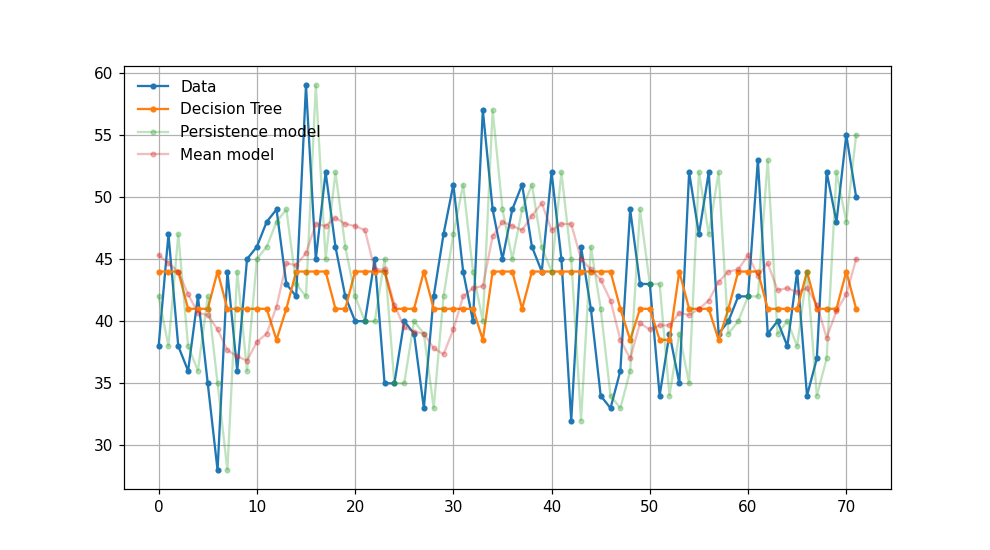

In [11]:
idx = 2
dt_tuned = DecisionTreeRegressor(random_state=0)
dt_tuned.set_params(**gs_res.loc[idx,'params'])
dt_tuned.fit(data_train[:, :-n_out], data_train[:, -n_out:])
plt.figure(figsize=(9,5))
plt.plot(testy,'.-',label='Data')
plt.plot(dt_tuned.predict(testX),'.-',label='Decision Tree')
plt.plot(testX[:,-1],'.-',label='Persistence model', alpha=0.3)
plt.plot(testX.mean(axis=1),'.-',label='Mean model',alpha=0.3)
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics.loc['MAE','DecisionTree'] = mean_absolute_error(testy, dt_tuned.predict(testX))
output_metrics.loc['RMSE','DecisionTree'] = rmse(testy, dt_tuned.predict(testX))

### 3.1.2 - Random Forest Regressor
The Random Forest Regressor is the second CART used in this notebook. This method combines an ensemble of DecisionTree and weight their output to generate the prediction. This technique allows the applciation a bootstrap operation on the data and the usage of only a portion of the features for each tree; both these features have the goal to mitigate the overfitting. <br>The main parameters of this CART are the following:
- "n_estimator": number of estimator to be trained by the algorithm.
- "criterion": the greedy algorithm based on the CART training process, need a function to decide the best split. The criterion specifies which function to be used.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "min_samples_split": The minimum number of samples required to split a node.
- "min_samples_leaf": The minimum number of samples required to be at a leaf node.
- "ccp_alpha": The tree can be pruned after its growth. To prune the tree a cost associated to the complexity is added in the cost function of the trainig; this parameter regulates the cost associated to the complexity.
- "bootstrap": if True, bootstrap procedure will be applied (always set to True in these examples)
- "max_features": The number of features to consider when looking for the best split. 

In [12]:
gs = GridSearchCV(estimator=RandomForestRegressor(random_state=0), cv=ts_splits,
                  param_grid={
                      'n_estimators': [10, 100, 1000],
                      'criterion':['mae'],
                      'max_depth':[10,100],
                      'min_samples_split': [5, 10, 100, 500],
                      'ccp_alpha': [0,0.001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=0, n_jobs=-1)
gs.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
print('Random Forest - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Random Forest - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Random Forest - training MAE = 6.053
Random Forest - test MAE = 5.306


,params,mean_test_score
18,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
42,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
6,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
30,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 10}",-5.814681
22,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
34,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
46,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
10,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 100}",-5.858149
45,"{'ccp_alpha': 0.001, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 10}",-5.859574
21,"{'ccp_alpha': 0, 'criterion': 'mae', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 10}",-5.859574


The best model of the above list is the number 18, since it is the "simplest" one among the group with best performances.

<IPython.core.display.Javascript object>


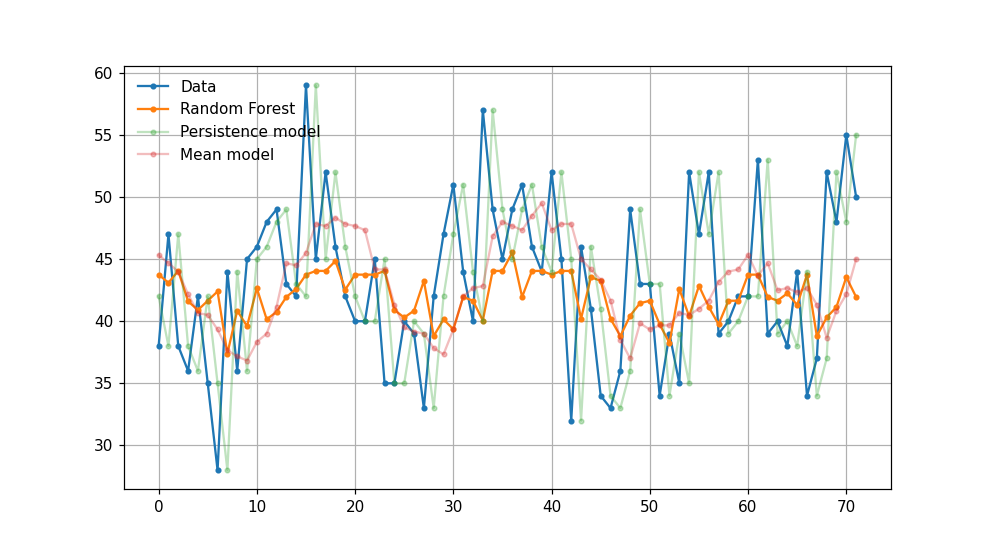

In [13]:
idx = 18
rf_tuned = RandomForestRegressor(random_state=0, n_jobs=-1)
rf_tuned.set_params(**gs_res.loc[idx,'params'])
rf_tuned.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
plt.figure(figsize=(9,5))
plt.plot(testy,'.-',label='Data')
plt.plot(rf_tuned.predict(testX),'.-',label='Random Forest')
plt.plot(testX[:,-1],'.-',label='Persistence model', alpha=0.3)
plt.plot(testX.mean(axis=1),'.-',label='Mean model',alpha=0.3)
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics.loc['MAE','RandomForest'] = mean_absolute_error(testy, rf_tuned.predict(testX))
output_metrics.loc['RMSE','RandomForest'] = rmse(testy, rf_tuned.predict(testX))

### 3.1.3 Gradient Boosting Regressor

The Gradient Boosting Regressor is the third CART used in this notebook. This technique builds an additive model and it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.<br> The main parameters of this CART are the following:
- "loss": the loss function to be optimized.
- "learning_rate": the learning rate multiplier for each additional tree.
- "subsample": the fraction of samples to be used for fitting the individual base learners. 
- "n_estimator": number of estimator to be trained by the algorithm.
- "criterion": the greedy algorithm based on the CART training process, need a function to decide the best split. The criterion specifies which function to be used.
- "max_depth": maximum depth of the tree. This parameter controls the maximum depth of the tree to avoid overfitting.
- "min_samples_split": The minimum number of samples required to split a node.
- "min_samples_leaf": The minimum number of samples required to be at a leaf node.
- "ccp_alpha": The tree can be pruned after its growth. To prune the tree a cost associated to the complexity is added in the cost function of the trainig; this parameter regulates the cost associated to the complexity.
- "bootstrap": if True, bootstrap procedure will be applied (always set to True in these examples)
- "max_features": The number of features to consider when looking for the best split.
- "validation_fraction" and "n_iter_no_change" and "tol": Parameters for the early stopping criterion (use validation dataset to evaluate the loss and if it does not decrease stop the training).

In [14]:
gs = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),cv=ts_splits,
                  param_grid={
                      'loss': ['ls','lad'],
                      'n_estimators': [10, 100],
                      'criterion':['mse'],
                      'max_depth':[10,100],
                      'min_samples_split': [100, 500],
                      'learning_rate': [0.0001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=2,n_jobs=-1)
gs.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
print('Gradient Boosting - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Gradient Boosting - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Gradient Boosting - training MAE = 5.763
Gradient Boosting - test MAE = 5.340


,params,mean_test_score
2,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 10}",-5.763129
3,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 100}",-5.763129
6,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 10}",-5.763129
7,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 100}",-5.763129
0,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 10}",-5.763295
4,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 100, 'n_estimators': 10}",-5.763295
1,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 100}",-5.764861
5,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'ls', 'max_depth': 100, 'min_samples_split': 100, 'n_estimators': 100}",-5.764861
11,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'lad', 'max_depth': 10, 'min_samples_split': 500, 'n_estimators': 100}",-5.816471
15,"{'criterion': 'mse', 'learning_rate': 0.0001, 'loss': 'lad', 'max_depth': 100, 'min_samples_split': 500, 'n_estimators': 100}",-5.816471


<IPython.core.display.Javascript object>


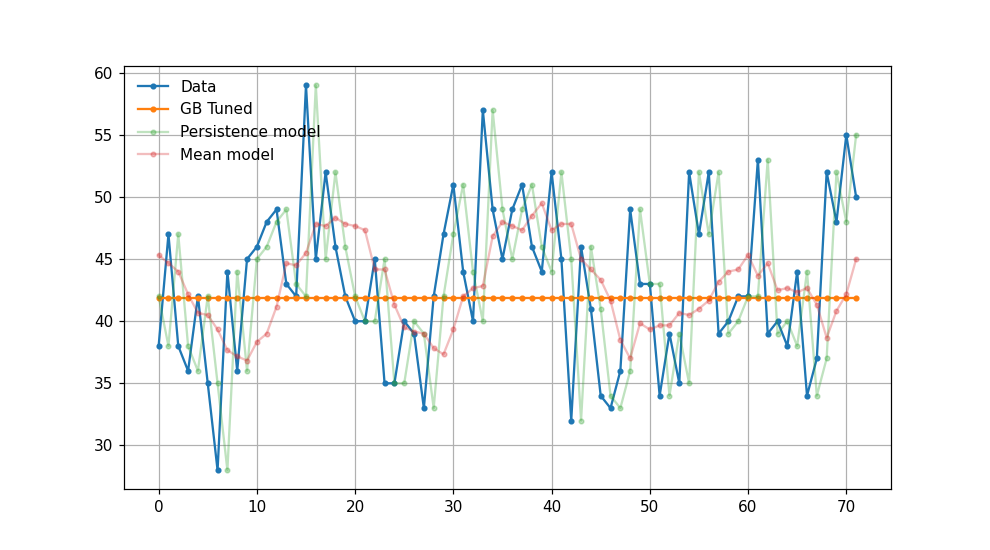

In [15]:
idx = 2
gb_tuned = GradientBoostingRegressor(random_state=0)
gb_tuned.set_params(**gs_res.loc[idx,'params'])
gb_tuned.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
plt.figure(figsize=(9,5))
plt.plot(testy,'.-',label='Data')
plt.plot(gb_tuned.predict(testX),'.-',label='GB Tuned')
plt.plot(testX[:,-1],'.-',label='Persistence model', alpha=0.3)
plt.plot(testX.mean(axis=1),'.-',label='Mean model',alpha=0.3)
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics.loc['MAE','GradientBoosting'] = mean_absolute_error(testy, gb_tuned.predict(testX))
output_metrics.loc['RMSE','GradientBoosting'] = rmse(testy, gb_tuned.predict(testX))

### 3.1.4 SuperLearner
The idea behind the SuperLearner is to combine different regressors and average all the outputs to obtain predicted values. <br> This type of regressor can be useful for a set of well performing models in order to balance out their individual weaknesses.


<IPython.core.display.Javascript object>


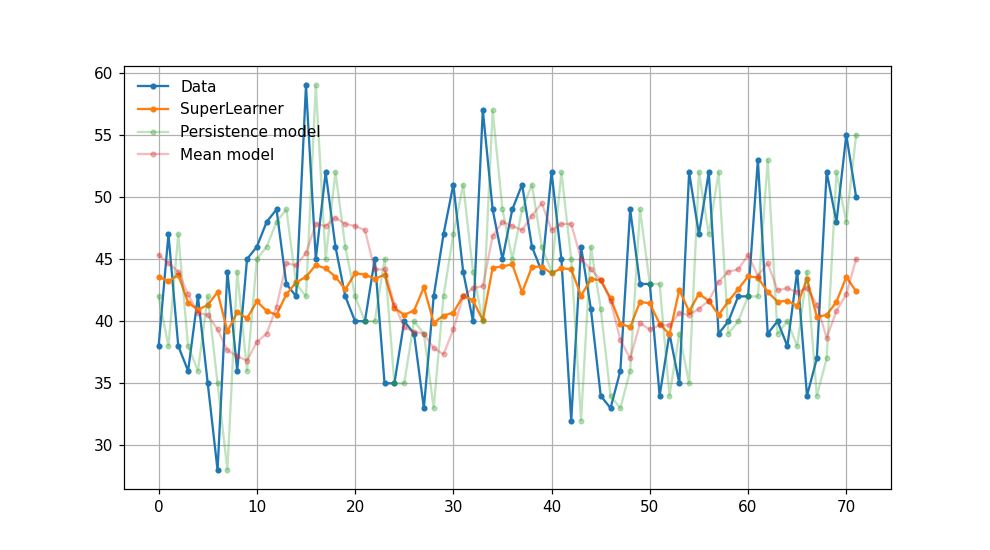

In [16]:
reg1 = dt_tuned
reg2 = rf_tuned
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('dt', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
plt.figure(figsize=(9,5))
plt.plot(testy,'.-',label='Data')
plt.plot(ereg.predict(testX),'.-',label='SuperLearner')
plt.plot(testX[:,-1],'.-',label='Persistence model', alpha=0.3)
plt.plot(testX.mean(axis=1),'.-',label='Mean model',alpha=0.3)
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics.loc['MAE','SuperLearner'] = mean_absolute_error(testy, ereg.predict(testX))
output_metrics.loc['RMSE','SuperLearner'] = rmse(testy, ereg.predict(testX))

Finally, the performances of all models are compared. <br>

<IPython.core.display.Javascript object>


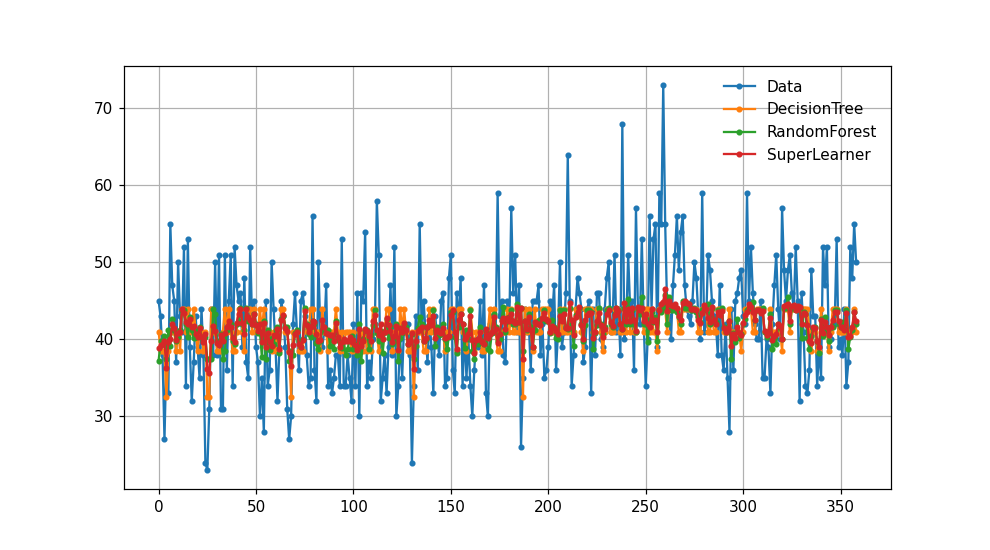

,Persistence,Mean,DecisionTree,RandomForest,GradientBoosting,SuperLearner
MAE,6.277778,5.682870,5.500000,5.305556,5.340447,5.261214
RMSE,7.751344,6.808361,6.916667,6.682933,6.568065,6.597304


In [17]:
plt.figure(figsize=(9,5))
plt.plot(data.values[:,-n_out:],'.-',label='Data')
plt.plot(dt_tuned.predict(data.values[:,:-n_out]),'.-',label='DecisionTree')
plt.plot(rf_tuned.predict(data.values[:,:-n_out]),'.-',label='RandomForest')
plt.plot(ereg.predict(data.values[:,:-n_out]),'.-',label='SuperLearner')
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics

### 3.2 Data Preprocessing Params Tuning
All the regressor shown in the 3.1 sections have the data preprocessing parameter fixed.<br>
In this section different "n_in" values will be used to generate the prediction.

In [18]:
############## Data Preprocessing Params ##############
n_in_list = [3,6,12,24] # Number of "previous data" to use as input
n_ahead = 1 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
n_out = 1 if single_output else n_ahead # Number of outputs of the model
train_size = 0.8 # Size of the training set
n_splits = 3 # Number of splits for cross validation
filename = 'daily-total-female-births.csv'
############## Data Preprocessing Params ##############

output_metrics_preproc = pd.DataFrame(data={'Persistence - 3':[float('nan'),float('nan')]},index=['MAE','RMSE'])

for n_in in n_in_list:
    print('Testing {}'.format(n_in))
    # load the dataset
    series = pd.read_csv(filename, header=0, index_col=0)

    # Transform the time series data into supervised learning
    data = series_to_supervised(series.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
    data_train = data.values[0:int(train_size*data.shape[0])]
    data_test = data.values[int(train_size*data.shape[0]):]
    testX, testy = data_test[:, :-n_out], data_test[:, -n_out:]
    
    # Naive regressors
    output_metrics_preproc.loc['MAE','Persistence - {}'.format(n_in)] = mean_absolute_error(testy, testX[:,-1])
    output_metrics_preproc.loc['RMSE', 'Persistence - {}'.format(n_in)] = rmse(testy, testX[:,-1])
    output_metrics_preproc.loc['MAE','Mean - {}'.format(n_in)] = mean_absolute_error(testy, testX.mean(axis=1))
    output_metrics_preproc.loc['RMSE','Mean - {}'.format(n_in)] = rmse(testy, testX.mean(axis=1))
    
    # Decision Tree
    gs_dt = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=ts_splits, 
                  param_grid={'criterion':['mae','mse'],'max_depth':[3,10,100,300],'min_samples_split': [5,10,100,1000],
                              'ccp_alpha': [0,0.0001,0.001,0.01,1]
                             },
                  scoring='neg_mean_absolute_error',
                  verbose = 0, n_jobs=-1)
    gs_dt.fit(data_train[:, :-n_out], data_train[:, -n_out:])
    yhat = gs_dt.best_estimator_.predict(testX)
    output_metrics_preproc.loc['MAE','Decision Tree - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','Decision Tree - {}'.format(n_in)] = rmse(testy, yhat)
    
    # Random Forest
    gs_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=0), cv=ts_splits,
                  param_grid={
                      'n_estimators': [10, 100, 1000],
                      'criterion':['mae'],
                      'max_depth':[10,100],
                      'min_samples_split': [5, 10, 100, 500],
                      'ccp_alpha': [0,0.001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=0, n_jobs=-1)
    gs_rf.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
    yhat = gs_rf.best_estimator_.predict(testX)
    output_metrics_preproc.loc['MAE','Random Forest - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','Random Forest - {}'.format(n_in)] = rmse(testy, yhat)
    
    # Gradient Boosting
    gs_gb  =GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),cv=ts_splits,
                  param_grid={
                      'loss': ['ls','lad'],
                      'n_estimators': [10, 100],
                      'criterion':['mse'],
                      'max_depth':[10,100],
                      'min_samples_split': [100, 500],
                      'learning_rate': [0.0001]
                  },
                  scoring='neg_mean_absolute_error',
                  verbose=2,n_jobs=-1)
    gs_gb.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
    yhat = gs_gb.best_estimator_.predict(testX)
    output_metrics_preproc.loc['MAE','Gradient Boosting - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','Gradient Boosting - {}'.format(n_in)] = rmse(testy, yhat)
    
    # Super Learner
    reg1 = gs_dt.best_estimator_
    reg2 = gs_rf.best_estimator_
    reg3 = LinearRegression()
    ereg = VotingRegressor(estimators=[('dt', reg1), ('rf', reg2), ('lr', reg3)])
    ereg = ereg.fit(data_train[:, :-n_out], data_train[:, -n_out:].ravel())
    yhat = ereg.predict(testX)
    output_metrics_preproc.loc['MAE','SuperLearner - {}'.format(n_in)] = mean_absolute_error(testy, yhat)
    output_metrics_preproc.loc['RMSE','SuperLearner - {}'.format(n_in)] = rmse(testy, yhat) 
    

Testing 3
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Testing 6
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Testing 12
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Testing 24
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [19]:
output_metrics_preproc.T

,MAE,RMSE
Persistence - 3,6.205479,7.698959
Mean - 3,5.552511,6.712400
Decision Tree - 3,5.153992,6.442686
Random Forest - 3,5.355479,6.609464
Gradient Boosting - 3,5.242046,6.500096
SuperLearner - 3,5.109161,6.371582
Persistence - 6,6.277778,7.751344
Mean - 6,5.682870,6.808361
Decision Tree - 6,5.500000,6.916667
Random Forest - 6,5.305556,6.682933


# 4 - Multivariate Analysis
This section will show the usage of CART models on a multivariate dataset. <br>
This dataset contains 19 different features such as air temperature, atmospheric pressure, and humidity collected from 2009 to 2016 with 1 records every hour. A complete <b>dataset analysis and feature engineering</b> can be found in the TensorFlow credits; for the sake of brevity, it will not be reported here. <br>
The goal is to <b>predict the air temperature</b> based on multiple features. Particularly interesting is the feature engineering on daily and yearly dependence:

- Two continuous variables (sine and cosine) will represent the time of the day and the time of the year. The usage of sine and cosine ensures unique values for both timings.


Credits: <br>https://www.bgc-jena.mpg.de/wetter/ <br>https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip <br>
https://www.tensorflow.org/tutorials/structured_data/time_series



<IPython.core.display.Javascript object>


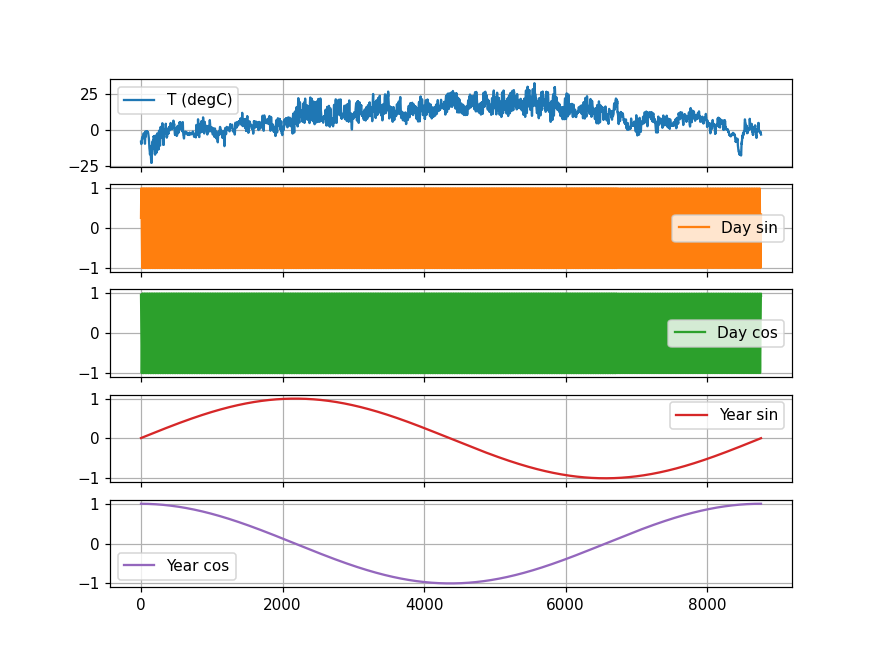

In [20]:
filename = 'weather_dataset.csv'
# load the dataset
df = pd.read_csv(filename, header=0, index_col=0, parse_dates=True)

# plot some features
feat = ['T (degC)','Day sin', 'Day cos', 'Year sin','Year cos']
df.iloc[0:8761].plot(y=feat,style='-',grid=True,subplots=True, figsize=(8,6))
plt.show(block=False)

<b>NOTE:</b> Before building any model, two naive models and a linear regression model are defined for performance comparison:
- The persistence model which simply predicts based on last seen record.
- The mean model which simply predicts the average of the training samples.
- Linear model: y = beta*X + alpha

In [21]:
############## Data Preprocessing Params ##############
n_in = 6 # Number of "previous data" to use as input
n_ahead = 1 # Number of step ahead to predict
single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
n_out = 1 if single_output else n_ahead # Number of outputs of the model
train_size = 0.7 # Size of the training set
n_splits = 5 # Number of splits for cross validation
features_tag = ['Day sin', 'Day cos', 'Year sin','Year cos']
target_tag = 'T (degC)'
filename = 'weather_dataset.csv'
############## Data Preprocessing Params ##############

output_multi_metrics = pd.DataFrame(data={'Persistence':[float('nan'),float('nan')],
                                    'Mean':[float('nan'),float('nan')],
                                    'Linear':[float('nan'),float('nan')],
                                    'Lasso':[float('nan'),float('nan')],
                                    'DecisionTree':[float('nan'),float('nan')],
                                    'RandomForest':[float('nan'),float('nan')],
                                    'GradientBoosting':[float('nan'),float('nan')],
                                    'SuperLearner':[float('nan'),float('nan')]},index=['MAE','RMSE'])

# load the dataset
df = pd.read_csv(filename, header=0, index_col=0)
df = df[features_tag + [target_tag]]

# Transform the time series data into supervised learning
data = series_to_supervised(df.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
data_target_only = series_to_supervised(df[[target_tag]].values, n_in=n_in, n_out=n_ahead, single_output=single_output)
train_size = int(train_size*data.shape[0])
data_train = data.values[0:train_size]
X_train, y_train = data_train[:,:-1], data_train[:,-1]
data_test = data.values[train_size:]
X_test, y_test = data_test[:, :-1], data_test[:, -1]

print('Train size: {}'.format(data_train.shape))
print('Test size: {}'.format(data_test.shape))
data.head()

Train size: (49059, 35)
Test size: (21026, 35)


,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
6,0.258819,0.965926,0.010049,0.999950,-8.05,0.500000,8.660254e-01,0.010766,0.999942,-8.88,...,1.000000,4.339955e-12,0.013633,0.999907,-9.67,0.965926,-0.258819,0.014349,0.999897,-9.17
7,0.500000,0.866025,0.010766,0.999942,-8.88,0.707107,7.071068e-01,0.011483,0.999934,-8.81,...,0.965926,-2.588190e-01,0.014349,0.999897,-9.17,0.866025,-0.500000,0.015066,0.999886,-8.10
8,0.707107,0.707107,0.011483,0.999934,-8.81,0.866025,5.000000e-01,0.012199,0.999926,-9.05,...,0.866025,-5.000000e-01,0.015066,0.999886,-8.10,0.707107,-0.707107,0.015783,0.999875,-7.66
9,0.866025,0.500000,0.012199,0.999926,-9.05,0.965926,2.588190e-01,0.012916,0.999917,-9.63,...,0.707107,-7.071068e-01,0.015783,0.999875,-7.66,0.500000,-0.866025,0.016500,0.999864,-7.04
10,0.965926,0.258819,0.012916,0.999917,-9.63,1.000000,4.339955e-12,0.013633,0.999907,-9.67,...,0.500000,-8.660254e-01,0.016500,0.999864,-7.04,0.258819,-0.965926,0.017216,0.999852,-7.41


### Important note:
The dimension of the dataset is massive so the training process is very slow; to mitigate this problem it has been decided to use just 2 years of data for the training process. Another possible solution could be to resample the data (for example: 1 point every 6 hours) but there are really no reason (in this work) to select on or the other option.

In [22]:
train_size = 2*365*24
data_train = data.values[0:train_size]
X_train, y_train = data_train[:,:-1], data_train[:,-1]
data_test = data.values[train_size:]
X_test, y_test = data_test[:, :-1], data_test[:, -1]

<IPython.core.display.Javascript object>


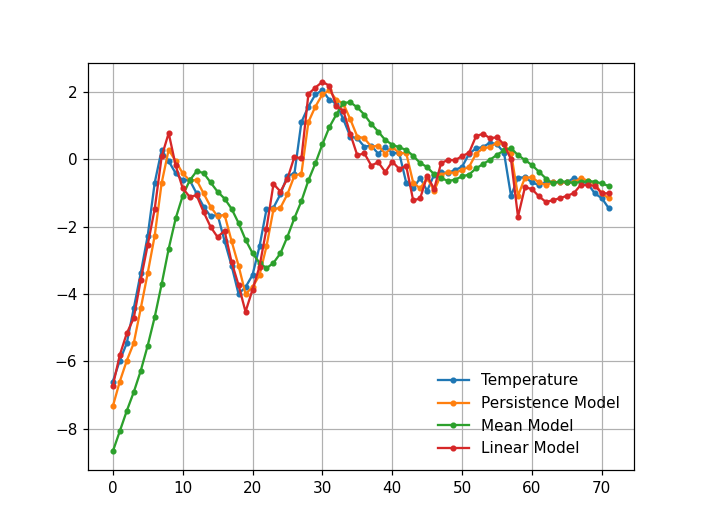

Persistence - test MAE = 0.716
Mean - test MAE = 1.978
Linear - test MAE = 3448392.037
Persistence - test RMSE = 1.018
Mean - test RMSE = 2.632
Linear - test RMSE = 226795817.094


,Persistence,Mean,Linear,Lasso,DecisionTree,RandomForest,GradientBoosting,SuperLearner
MAE,0.716025,1.978370,3.448392e+06,NaN,NaN,NaN,NaN,NaN
RMSE,1.018404,2.632359,2.267958e+08,NaN,NaN,NaN,NaN,NaN


In [23]:
X_target_only, y_target_only = data_target_only.values[train_size:, :-1], data_target_only.values[train_size:, -1]

y_pers =  X_target_only[:,-1]
y_mean =  X_target_only.mean(axis=1)
reg = LinearRegression().fit(X_train, y_train)
y_lin = reg.predict(X_test)

n_days = 3

plt.figure()
plt.plot(y_test[0:24*n_days],'.-',label='Temperature')
plt.plot(y_pers[0:24*n_days],'.-',label='Persistence Model')
plt.plot(y_mean[0:24*n_days],'.-',label='Mean Model')
plt.plot(y_lin[0:24*n_days], '.-',label='Linear Model')
plt.legend(frameon=False)
plt.grid(True)

print('Persistence - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_pers)))
print('Mean - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_mean)))
print('Linear - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_lin)))
print('Persistence - test RMSE = {:.3f}'.format(rmse(y_test, y_pers)))
print('Mean - test RMSE = {:.3f}'.format(rmse(y_test, y_mean)))
print('Linear - test RMSE = {:.3f}'.format(rmse(y_test, y_lin)))
output_multi_metrics.loc['MAE','Persistence'] = mean_absolute_error(y_test, y_pers)
output_multi_metrics.loc['MAE','Mean'] = mean_absolute_error(y_test, y_mean)
output_multi_metrics.loc['MAE','Linear'] = mean_absolute_error(y_test, y_lin)
output_multi_metrics.loc['RMSE','Persistence'] = rmse(y_test, y_pers)
output_multi_metrics.loc['RMSE','Mean'] = rmse(y_test, y_mean)
output_multi_metrics.loc['RMSE','Linear'] = rmse(y_test, y_lin)
output_multi_metrics

### Spiega che dal RMSE vs MAE si vedono degli outlier e magari mettici pure un LASSO

<IPython.core.display.Javascript object>


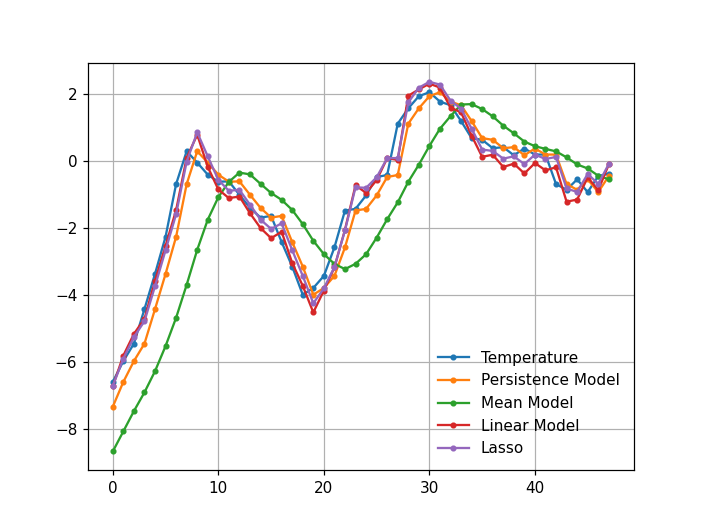

Linear - test MAE = 0.536
Linear - test RMSE = 0.793


In [24]:
reg.coef_
reg_lasso = Lasso(alpha=0.1).fit(X_train, y_train)
y_lasso = reg_lasso.predict(X_test)

plt.figure()
plt.plot(y_test[0:48],'.-',label='Temperature')
plt.plot(y_pers[0:48],'.-',label='Persistence Model')
plt.plot(y_mean[0:48],'.-',label='Mean Model')
plt.plot(y_lin[0:48], '.-',label='Linear Model')
plt.plot(y_lasso[0:48], '.-',label='Lasso')
plt.legend(frameon=False)
plt.grid(True)
list(zip(reg.coef_,reg_lasso.coef_))

print('Linear - test MAE = {:.3f}'.format(mean_absolute_error(y_test, y_lasso)))
print('Linear - test RMSE = {:.3f}'.format(rmse(y_test, y_lasso)))

## 4.1 Multivariate Analysis

### 4.1.1 Decision Tree

In [27]:
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), cv=TimeSeriesSplit(n_splits=n_splits), 
                  param_grid={
                      'criterion':['mae'],
                      'max_depth':[5,10,20],
                      'min_samples_split': [100],
                      'ccp_alpha': [0,0.0001,0.1]                      
                  },
                  scoring='neg_mean_absolute_error',
                  verbose = 10, n_jobs=-1)
gs.fit(X_train, y_train)
print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(y_test, gs.best_estimator_.predict(X_test))))
print('Decision Tree - test RMSE = {:.3f}'.format(rmse(y_test, gs.best_estimator_.predict(X_test))))
gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
gs_res.head(10)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Decision Tree - training MAE = 0.976
Decision Tree - test MAE = 0.596


ValueError: Found input variables with inconsistent numbers of samples: [69, 52565]

perchè scegli uno o un altro

<IPython.core.display.Javascript object>


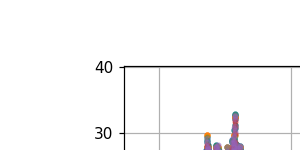

ValueError: X has 24 features, but DecisionTreeRegressor is expecting 6 features as input.

In [29]:
idx = 2
dt_tuned_multi = DecisionTreeRegressor(random_state=0)
dt_tuned_multi.set_params(**gs_res.loc[idx,'params'])
dt_tuned_multi.fit(X_train, y_train)
plt.figure(figsize=(9,5))
plt.plot(y_test,'.-',label='Temperature')
plt.plot(dt_tuned_multi.predict(X_test),'.-',label='GB Tuned')
plt.plot(y_pers,'.-',label='Persistence model', alpha=0.3)
plt.plot(y_mean,'.-',label='Mean model',alpha=0.3)
plt.plot(y_lasso,'.-',label='Lasso model',alpha=0.3)
plt.legend(frameon=False, loc=0)
plt.grid()
output_metrics.loc['MAE','GradientBoosting'] = mean_absolute_error(testy, gb_tuned.predict(testX))
output_metrics.loc['RMSE','GradientBoosting'] = rmse(testy, gb_tuned.predict(testX))

In [ ]:
# ############## Params START ##############
# n_in = 6 # Number of "previous data" to use as input
# n_ahead = 1 # Number of step ahead to predict
# single_output = True # If True, predicts only the last n_ahead value; else it predicts all the values "in between"
# n_out = 1 if single_output else n_ahead # Number of outputs of the model
# train_size = 0.8 # Size of the training set
# n_splits = 5 # Number of splits for cross validation
# filename = 'sunspots.csv'
# ############## Params End ##############

# # load the dataset
# series = pd.read_csv(filename, header=0, index_col=0)

# # Transform the time series data into supervised learning
# data = series_to_supervised(series.values, n_in=n_in, n_out=n_ahead, single_output=single_output)
# data_train = data.values[0:int(train_size*data.shape[0])]
# data_test = data.values[int(train_size*data.shape[0]):]

# gs = GridSearchCV(estimator=model, cv=ts_splits, 
#                   param_grid={
#                       'criterion':['mae','mse'],
#                       'max_depth':[3],
#                       'min_samples_split': [5],
#                       'ccp_alpha': [0,1]                      
#                   },
#                   scoring='neg_mean_absolute_error')
# gs.fit(data_train[:, :-n_out], data_train[:, -n_out:])
# print('Decision Tree - training MAE = {:.3f}'.format(abs(gs.cv_results_['mean_test_score'][0])))
# print('Decision Tree - test MAE = {:.3f}'.format(mean_absolute_error(testy, gs.best_estimator_.predict(testX))))
# gs_res = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['params','mean_test_score']]
# gs_res.head(15)